# Курсовой проект

Здравствуйте, спасибо за курс, было здорово :)

К сожалению, я смотрел "Консультацию по итоговому проекту" в последние минуты перед сдачей курсового проекта, поэтому извините, что не соблел все ваши рекомендации.

Мне будет очень полезно если проясните некоторые вопросы, с которыми я столкнулся в ходе проекта:
* Как вам идея выкусывать из датасета признаки по одному, например, можем "нормализовать" цену квартиры по площади, тем самым избавиться от площади? Потом нормализовать по коэффициенту богатства района? Вы показали `groupby()` по нескольким признакам - это альтернатива "моему" подходу?
* Сначала я пытался добавлять по одному признаку в датасет и смотреть как меняется качество обучения. Потом я понял, что по отдельности параметры оказывают разное влияние, чем этот же признак вместе с другими. Дело усложнялось тем, что я пытался оптимизировать выбросы в признаках. Правильно ли я понимаю, что сначала надо просто устранить пропуски и выбросы медианами, а потом уже докручивать признаки? Правильно ли будет улучшать качество признаков с большим весом после стандартизации? Я понял, что зачастую новый признак (ранг богатства района) дает больший выигрыш.
* Почему-то у меня после какого-то момента перестала работать картинка с весами признаков для линейной модели, и мне пришлось ориентироваться на качество. На консультации я увидел, что параметры можно было бы взять и из дерева.
* Я когда смотрел на коэффициенты линейной модели и увидел, что площадь жилая и кухни имеют малые значения, то просто их удалил, возможно, стоило их изменять. Но я подумал, что в признаке слишком много пропусков, да и какие-то подозрительно малые кухни.
* можно ли использовать в `fit` абсолютные значения, например, цена за метр квадратный больше **12500**? Должен ли код быть универсальным, или код отражает конкретный датасет?
* При GridSearchCV я сократил записи датасета, поскольку разбил датасет на train и valid, этого делать не нужно, но я побоюсь изменять код, т.к. сдавать через несколько минут.

## Пути

In [207]:
TRAIN_DATASET_PATH = './train.csv'
PREPARED_DATASET_PATH = './train_prepared.csv'
TEST_DATASET_PATH = './test.csv'
PREDICTIONS_PATH = "./predictions_makarevich.csv"

In [208]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [209]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1**, **Ecology_2**, **Ecology_3** - экологические показатели местности
* **Social_1**, **Social_2**, **Social_3** - социальные показатели местности
* **Healthcare_1**, **Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1**, **Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

## Features и target

In [210]:
target_name = 'Price'

def get_feature_names(df, target):
    # Id to str
    # df['Id'] = df['Id'].astype(str)
    id_column_name = 'Id'

    # Ecology_2      10000 non-null  category
    # Ecology_3      10000 non-null  category
    # Shops_2        10000 non-null  category
    # Id             6700  non-null  object    (сам убрал)
    feature_names = df.select_dtypes(exclude=['category', 'object']).columns.tolist()
    if target in feature_names:
        feature_names.remove(target)
    if id_column_name in feature_names:
        feature_names.remove(id_column_name)

    if "LifeSquare" in feature_names:
        feature_names.remove("LifeSquare")  # ухудшает точность
    if "KitchenSquare" in feature_names:
        feature_names.remove("KitchenSquare")  # ухудшает точность
    if "DistrictId" in feature_names:
        feature_names.remove("DistrictId")
    return feature_names

## Helpers

### DataPipeline

In [211]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.ranked_districts = None
        self.counts_by_district = None
        
    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчет медиан
        self.medians = df[['LifeSquare', 'Healthcare_1', 'Square']].median()

        prices_by_district_sorted = df.groupby('DistrictId')['Price'].median().sort_values()
        self.ranked_districts = prices_by_district_sorted.index.to_list()
        counts_by_district = df.groupby('DistrictId')['DistrictId'].agg('count')
        district_ids = counts_by_district.index.to_list()
        counts = counts_by_district.values
        self.counts_by_district = dict(zip(district_ids, counts))

    def get_runk(self, district_id):
        # TODO: есть пропуски 0 209 205
        #  print(min(ranked_districts), max(ranked_districts), len(ranked_districts))
        try:
            return self.ranked_districts.index(district_id)
        except:
            return 40 # TODO:

    def get_runk_quality(self, district_id):
        # TODO: есть пропуски 0 209 205
        #  print(min(ranked_districts), max(ranked_districts), len(ranked_districts))
        try:
            return self.counts_by_district[district_id]
        except:
            return 0 # TODO:

    def get_rooms(self, square):
        if square < 48.125: return 1
        if square < 66.64: return 2
        if square < 88.04: return 3
        if square < 107.375: return 4
        if square >= 107.375: return 5
       
    def transform(self, df):
        """Трансформация данных"""
        
        # 1. Пропуски
        df[['LifeSquare', 'Healthcare_1']] =\
            df[['LifeSquare', 'Healthcare_1']].fillna(self.medians)

        # 2. Выбросы (outliers)
        df['SquareOutlier'] = 0
        df.loc[df['Square'] < 11, 'SquareOutlier'] = 1
        # df.loc[df['Square'] < 11, 'Square'] = df.loc[df['Square'] < 11, 'Square'] * 10
        df.loc[df['Square'] < 11, 'Square'] = self.medians['Square']

        df['RoomsOutlier'] = 0
        rooms_outlier_condition = (df['Rooms'] > 5) | (df['Rooms'] == 1)
        df.loc[rooms_outlier_condition, 'RoomsOutlier'] = 1
        df.loc[rooms_outlier_condition, 'Rooms'] = df[rooms_outlier_condition]['Square'].apply(lambda square: self.get_rooms(square))
        
        # 3. Новые фичи (features)
        df['HouseAge'] = 2021 - df['HouseYear']
        df['RichDistrictRank'] = df['DistrictId'].apply(lambda id: self.get_runk(id))
        df['RichDistrictRankQuality'] = df['DistrictId'].apply(lambda id: self.get_runk_quality(id))

        first_last_condition = (df['HouseFloor'] == df['Floor']) | (df['Floor'] == 1)
        df['FirstLastFloor'] = first_last_condition
        
        # 4. Обработка категорий
        # Ecology_2      10000 non-null  category
        # Ecology_3      10000 non-null  category
        # Shops_2        10000 non-null  category
        df = pd.concat([df, pd.get_dummies(df['Ecology_2'], prefix='Ecology_2')], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Ecology_3'], prefix='Ecology_3')], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Shops_2'], prefix='Shops_2')], axis=1)
        
        return df


### reduce_mem_usage

In [212]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

### evaluate_preds

In [213]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

### scale_features

In [214]:
scaler = StandardScaler()
scaler = RobustScaler()

def scale_features(df, fit=False):
    feature_names = get_feature_names(df, 'Price')  #TODO: 'Price'
    if fit:
        stand_features = scaler.fit_transform(df[feature_names])
    else:
        stand_features = scaler.transform(df[feature_names])
    new_df = pd.DataFrame(stand_features, columns=feature_names)
    return new_df
    # return df

## Изучение цели и признаков

In [215]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


### Цель 'Price'

In [216]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750


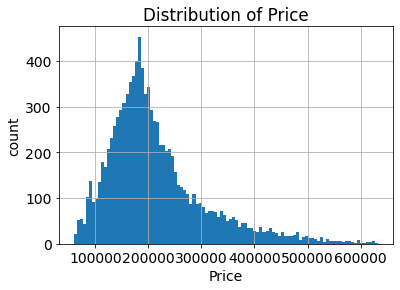

In [217]:
feature_name = 'Price'
df[feature_name].hist(bins=100)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

Распределение цены близко к нормальному.

In [218]:
df['Price'].describe()

count     10000.000000
mean     214138.937500
std       92872.273438
min       59174.777344
25%      153872.628906
50%      192269.648438
75%      249135.460938
max      633233.437500
Name: Price, dtype: float64

Пропусков нет

**Вывод:**
- Распределение цены близко к нормальному
- Пропусков нет
- **А выбросов?**

### Признаки площади

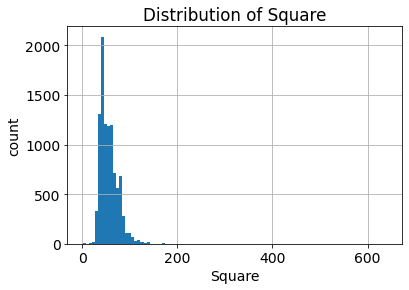

In [219]:
feature_name = 'Square'
df[feature_name].hist(bins=100)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

In [220]:
square_df = df[['Id', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Price']]

In [221]:
square_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int16  
 1   Rooms          10000 non-null  float32
 2   Square         10000 non-null  float32
 3   LifeSquare     7887 non-null   float32
 4   KitchenSquare  10000 non-null  float32
 5   Price          10000 non-null  float32
dtypes: float32(5), int16(1)
memory usage: 215.0 KB


In [222]:
square_df.describe()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Price
count,10000.00000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000
mean,8383.40770,1.890500,56.315720,37.199665,6.273300,214138.937500
std,4859.01902,0.839522,21.058716,86.241219,28.560839,92872.273438
min,0.00000,0.000000,1.136859,0.370619,0.000000,59174.777344
25%,4169.50000,1.000000,41.774879,22.769833,1.000000,153872.628906
50%,8394.50000,2.000000,52.513309,32.781261,6.000000,192269.648438
75%,12592.50000,2.000000,65.900627,45.128803,9.000000,249135.460938
max,16798.00000,19.000000,641.065186,7480.592285,2014.000000,633233.437500


In [223]:
square_df['rub_m2'] = df['Price'] / df['Square']

In [224]:
square_df[square_df['Square'] < 11]

,Id,Rooms,Square,LifeSquare,KitchenSquare,Price,rub_m2
161,6782,1.0,2.954309,5.257278,1.0,438005.187500,148259.796875
328,4504,3.0,4.390331,5.610772,1.0,161379.062500,36757.835938
1401,9487,1.0,5.129221,5.549458,1.0,369472.406250,72032.843750
4496,15744,1.0,1.988943,2.642219,1.0,458378.781250,230463.531250
4800,7657,1.0,4.502784,4.618547,1.0,483283.500000,107329.937500
5009,11526,1.0,4.633498,1.969969,1.0,107604.265625,23223.115234
7033,1748,2.0,5.497061,67.628716,1.0,412511.093750,75042.117188
7470,14786,1.0,1.136859,4.525736,1.0,181434.828125,159593.109375
8572,10202,1.0,2.596351,4.604943,1.0,137597.593750,52996.527344
8805,10527,1.0,4.380726,40.805836,1.0,97560.718750,22270.445312


In [225]:
square_max_value = np.quantile(df['Square'], q=0.999)
high_square_df = square_df[square_df['Square'] > square_max_value][['Id', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'rub_m2', 'Price']]
high_square_df
# df[square_df['Square'] > square_max_value].describe()

,Id,Rooms,Square,LifeSquare,KitchenSquare,rub_m2,Price
726,28,2.0,604.705994,NaN,1.0,310.427307,187717.250000
1606,3718,3.0,190.857681,107.376167,19.0,1774.327637,338644.062500
1776,16568,4.0,200.334534,201.627365,25.0,2638.389404,528560.500000
1906,5548,5.0,275.645294,233.949310,26.0,1651.633057,455264.875000
2790,15947,4.0,185.906403,84.830078,31.0,1830.347168,340273.250000
7010,2307,1.0,409.425171,410.639740,10.0,220.969391,90470.429688
7644,7917,0.0,212.932358,211.231125,0.0,1419.282837,302211.250000
8011,3233,4.0,186.692596,87.487083,32.0,2268.132080,423443.468750
9229,11602,2.0,641.065186,638.163208,10.0,208.293457,133529.687500
9307,4249,5.0,198.930176,123.139862,10.0,1737.620850,345665.218750


### Признак rub_m2

In [226]:
rub_m2 = df[['Id', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Price']]
rub_m2['rub_m2'] = df['Price'] / df['Square']
rub_m2

,Id,Rooms,Square,LifeSquare,KitchenSquare,Price,rub_m2
0,11809,3.0,115.027313,NaN,10.0,305018.875000,2651.708252
1,3013,1.0,39.832523,23.169222,8.0,177734.546875,4462.045898
2,8215,3.0,78.342216,47.671970,10.0,282078.718750,3600.596680
3,2352,1.0,40.409908,NaN,1.0,168106.000000,4160.019531
4,13866,2.0,64.285065,38.562515,9.0,343995.093750,5351.088867
...,...,...,...,...,...,...,...
9995,1260,2.0,49.090729,33.272625,6.0,119367.453125,2431.568115
9996,16265,2.0,64.307686,37.038422,9.0,199715.156250,3105.618652
9997,2795,1.0,29.648056,16.555363,5.0,165953.906250,5597.463379
9998,14561,1.0,32.330292,22.326870,5.0,171842.406250,5315.213379


In [227]:
rub_m2.describe()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Price,rub_m2
count,10000.00000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,1.890500,56.315720,37.199665,6.273300,214138.937500,3988.376709
std,4859.01902,0.839522,21.058716,86.241219,28.560839,92872.273438,3755.434814
min,0.00000,0.000000,1.136859,0.370619,0.000000,59174.777344,208.293457
25%,4169.50000,1.000000,41.774879,22.769833,1.000000,153872.628906,2918.525391
50%,8394.50000,2.000000,52.513309,32.781261,6.000000,192269.648438,3910.052246
75%,12592.50000,2.000000,65.900627,45.128803,9.000000,249135.460938,4692.375977
max,16798.00000,19.000000,641.065186,7480.592285,2014.000000,633233.437500,230463.531250


In [228]:
rub_m2[rub_m2['Rooms'] == 1].describe()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Price,rub_m2
count,3705.000000,3705.0,3705.000000,2827.000000,3705.000000,3705.000000,3705.000000
mean,8406.774629,1.0,41.323250,25.159000,6.525776,159850.828125,4149.077637
std,4851.019498,0.0,11.427643,14.202312,46.385113,51892.449219,5688.871094
min,0.000000,1.0,1.136859,0.370619,0.000000,60502.582031,220.969391
25%,4063.000000,1.0,36.692589,19.681269,1.000000,128711.101562,3000.069336
50%,8486.000000,1.0,40.406590,21.663929,6.000000,154979.500000,3947.468506
75%,12628.000000,1.0,43.565369,24.232241,8.000000,182212.203125,4745.314453
max,16798.000000,1.0,409.425171,410.639740,2014.000000,594565.312500,230463.531250


In [229]:
rub_m2[rub_m2['Rooms'] == 2].describe()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Price,rub_m2
count,3880.000000,3880.0,3880.000000,3052.000000,3880.000000,3880.000000,3880.000000
mean,8399.308763,2.0,56.788319,35.971897,5.636340,215256.015625,3905.228027
std,4844.073390,0.0,16.846598,17.609076,4.745253,73452.226562,1719.378662
min,14.000000,2.0,5.497061,0.795539,0.000000,59174.777344,208.293457
25%,4222.000000,2.0,47.873233,29.915167,1.000000,174516.726562,2883.604858
50%,8383.000000,2.0,55.841812,32.552135,6.000000,200320.757812,3902.617310
75%,12636.250000,2.0,63.324704,36.042816,8.000000,243492.281250,4684.455811
max,16794.000000,2.0,641.065186,638.163208,78.000000,633233.437500,75042.117188


In [230]:
rub_m2[rub_m2['Rooms'] == 3].describe()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Price,rub_m2
count,2235.000000,2235.0,2235.000000,1842.000000,2235.000000,2235.000000,2235.000000
mean,8351.163758,3.0,76.903351,54.942810,6.801790,289337.437500,3851.162354
std,4900.288837,0.0,15.725385,174.162567,6.390184,104456.468750,1748.343750
min,5.000000,3.0,4.390331,0.641822,0.000000,64298.214844,752.588684
25%,4218.500000,3.0,65.995701,43.679016,1.000000,218501.023438,2824.122681
50%,8346.000000,3.0,77.413643,46.960480,7.000000,268723.156250,3857.987549
75%,12451.500000,3.0,83.215958,51.669754,10.000000,349766.968750,4624.458496
max,16797.000000,3.0,190.857681,7480.592285,123.000000,627525.062500,49281.195312


In [231]:
rub_m2[rub_m2['Rooms'] == 4].describe()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Price,rub_m2
count,150.000000,150.0,150.000000,141.000000,150.000000,150.000000,150.000000
mean,8311.353333,4.0,98.377533,65.667068,8.506667,383251.031250,3998.205078
std,4881.505357,0.0,23.819553,22.167955,4.943637,117182.117188,1174.379517
min,88.000000,4.0,44.128948,1.451846,0.000000,82342.773438,810.825439
25%,4453.500000,4.0,84.053099,53.804089,6.000000,299614.281250,3362.476807
50%,7779.500000,4.0,98.668056,64.946548,9.000000,377524.234375,4113.477783
75%,12696.500000,4.0,104.655209,72.482796,10.000000,465675.132812,4726.014404
max,16641.000000,4.0,200.334534,201.627365,32.000000,624156.000000,6696.498047


In [232]:
rub_m2[rub_m2['Rooms'] > 4].describe()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Price,rub_m2
count,22.000000,22.000000,22.000000,20.000000,22.000000,22.000000,22.000000
mean,6417.318182,6.136364,110.382622,78.312836,9.045455,372063.218750,3616.292969
std,4421.325877,3.226312,55.921413,45.204533,7.286499,151785.718750,1228.619751
min,238.000000,5.000000,39.906082,21.779287,0.000000,78364.617188,1651.633057
25%,3608.000000,5.000000,66.981851,52.363525,5.250000,276360.890625,2719.989929
50%,5259.500000,5.000000,111.590660,73.776550,9.000000,393471.656250,3699.731689
75%,8636.500000,5.000000,120.935068,84.166031,10.000000,477602.312500,4559.516113
max,14865.000000,19.000000,275.645294,233.949310,30.000000,622888.812500,5411.548828


In [233]:
rub_m2.describe()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Price,rub_m2
count,10000.00000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,1.890500,56.315720,37.199665,6.273300,214138.937500,3988.376709
std,4859.01902,0.839522,21.058716,86.241219,28.560839,92872.273438,3755.434814
min,0.00000,0.000000,1.136859,0.370619,0.000000,59174.777344,208.293457
25%,4169.50000,1.000000,41.774879,22.769833,1.000000,153872.628906,2918.525391
50%,8394.50000,2.000000,52.513309,32.781261,6.000000,192269.648438,3910.052246
75%,12592.50000,2.000000,65.900627,45.128803,9.000000,249135.460938,4692.375977
max,16798.00000,19.000000,641.065186,7480.592285,2014.000000,633233.437500,230463.531250


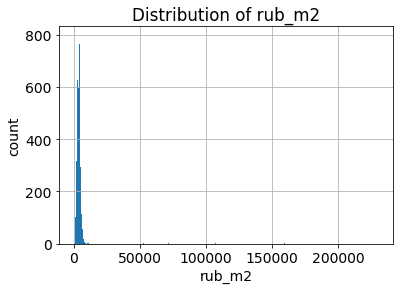

In [234]:
feature_name = 'rub_m2'
rub_m2[feature_name].hist(bins=1000)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

In [235]:
rub_m2[(rub_m2['Square'] < 11) | (rub_m2['rub_m2'] > 12500)]

,Id,Rooms,Square,LifeSquare,KitchenSquare,Price,rub_m2
161,6782,1.0,2.954309,5.257278,1.0,438005.187500,148259.796875
328,4504,3.0,4.390331,5.610772,1.0,161379.062500,36757.835938
1401,9487,1.0,5.129221,5.549458,1.0,369472.406250,72032.843750
4496,15744,1.0,1.988943,2.642219,1.0,458378.781250,230463.531250
4800,7657,1.0,4.502784,4.618547,1.0,483283.500000,107329.937500
5009,11526,1.0,4.633498,1.969969,1.0,107604.265625,23223.115234
7033,1748,2.0,5.497061,67.628716,1.0,412511.093750,75042.117188
7470,14786,1.0,1.136859,4.525736,1.0,181434.828125,159593.109375
8572,10202,1.0,2.596351,4.604943,1.0,137597.593750,52996.527344
8805,10527,1.0,4.380726,40.805836,1.0,97560.718750,22270.445312


In [236]:
rub_m2[rub_m2['rub_m2'] > 12500]

,Id,Rooms,Square,LifeSquare,KitchenSquare,Price,rub_m2
161,6782,1.0,2.954309,5.257278,1.0,438005.187500,148259.796875
328,4504,3.0,4.390331,5.610772,1.0,161379.062500,36757.835938
1401,9487,1.0,5.129221,5.549458,1.0,369472.406250,72032.843750
4496,15744,1.0,1.988943,2.642219,1.0,458378.781250,230463.531250
4800,7657,1.0,4.502784,4.618547,1.0,483283.500000,107329.937500
5009,11526,1.0,4.633498,1.969969,1.0,107604.265625,23223.115234
7033,1748,2.0,5.497061,67.628716,1.0,412511.093750,75042.117188
7470,14786,1.0,1.136859,4.525736,1.0,181434.828125,159593.109375
8572,10202,1.0,2.596351,4.604943,1.0,137597.593750,52996.527344
8805,10527,1.0,4.380726,40.805836,1.0,97560.718750,22270.445312


In [237]:
rub_m2_max = np.quantile(rub_m2['rub_m2'], q=0.995)
print('rub_m2_max: ', rub_m2_max)
rub_m2[rub_m2['rub_m2'] > rub_m2_max]

rub_m2_max:  8137.7981054687225


,Id,Rooms,Square,LifeSquare,KitchenSquare,Price,rub_m2
51,12774,2.0,62.747509,28.196814,8.0,555661.937500,8855.521484
161,6782,1.0,2.954309,5.257278,1.0,438005.187500,148259.796875
328,4504,3.0,4.390331,5.610772,1.0,161379.062500,36757.835938
402,14001,1.0,44.098766,44.267551,1.0,381937.406250,8660.954102
567,6488,1.0,44.341019,44.323166,1.0,367188.500000,8281.011719
651,5632,3.0,54.036552,43.891273,8.0,556053.812500,10290.327148
753,2018,1.0,33.521641,30.155170,1.0,381912.156250,11393.002930
1068,6036,1.0,46.248238,NaN,0.0,516315.781250,11164.009766
1203,13129,1.0,46.765167,48.240135,1.0,404790.562500,8655.813477
1401,9487,1.0,5.129221,5.549458,1.0,369472.406250,72032.843750


In [238]:
rub_m2.sort_values(by="rub_m2")

,Id,Rooms,Square,LifeSquare,KitchenSquare,Price,rub_m2
9229,11602,2.0,641.065186,638.163208,10.0,133529.687500,208.293457
7010,2307,1.0,409.425171,410.639740,10.0,90470.429688,220.969391
726,28,2.0,604.705994,NaN,1.0,187717.250000,310.427307
6127,7590,3.0,94.417145,56.749168,11.0,71057.273438,752.588684
244,203,4.0,101.554253,22.630373,9.0,82342.773438,810.825439
...,...,...,...,...,...,...,...
7033,1748,2.0,5.497061,67.628716,1.0,412511.093750,75042.117188
4800,7657,1.0,4.502784,4.618547,1.0,483283.500000,107329.937500
161,6782,1.0,2.954309,5.257278,1.0,438005.187500,148259.796875
7470,14786,1.0,1.136859,4.525736,1.0,181434.828125,159593.109375


In [239]:
rub_m2_min = np.quantile(rub_m2['rub_m2'], q=0.05)
rub_m2[rub_m2['rub_m2'] < rub_m2_min]

,Id,Rooms,Square,LifeSquare,KitchenSquare,Price,rub_m2
29,5273,2.0,53.199650,32.459053,9.0,94061.945312,1768.093262
30,5931,1.0,43.033398,NaN,1.0,72659.968750,1688.455322
38,7679,2.0,55.521797,NaN,0.0,93217.750000,1678.939697
49,5474,2.0,63.791065,40.757587,10.0,91594.312500,1435.848633
62,3849,1.0,44.669037,NaN,1.0,80356.320312,1798.926636
...,...,...,...,...,...,...,...
9834,4956,1.0,44.881535,NaN,1.0,74910.828125,1669.078979
9846,1205,2.0,148.671936,100.201653,1.0,152464.843750,1025.511963
9875,922,2.0,58.270531,31.491682,11.0,114627.781250,1967.165527
9901,671,2.0,55.869625,54.177711,10.0,63900.207031,1143.737915


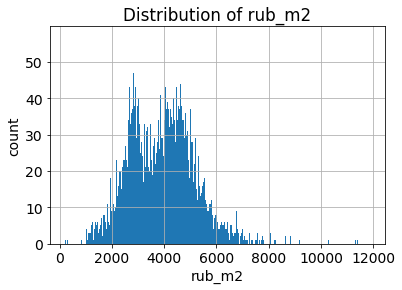

In [240]:
feature_name = 'rub_m2'
rub_m2[rub_m2[feature_name] < 12500][feature_name].hist(bins=1000)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

### Признак DistrictId и rub_m2

In [241]:
rub_m2_district = df[['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Price']]
rub_m2_district['rub_m2'] = df['Price'] / df['Square']
# rub_m2_district

In [242]:
rub_m2_district[(rub_m2_district['rub_m2'] > 4000) & (rub_m2_district['rub_m2'] < 5000)]['DistrictId'].value_counts()


53     94
8      80
11     71
61     71
46     68
       ..
193     1
162     1
116     1
112     1
209     1
Name: DistrictId, Length: 170, dtype: int64

### Признак ни первый ни последний

In [243]:
floor_df = df[['Id', 'Square', 'HouseFloor', 'Floor', 'Price']]
floor_df['rub_m2'] = df['Price'] / df['Square']
floor_df

,Id,Square,HouseFloor,Floor,Price,rub_m2
0,11809,115.027313,10.0,4,305018.875000,2651.708252
1,3013,39.832523,8.0,7,177734.546875,4462.045898
2,8215,78.342216,17.0,2,282078.718750,3600.596680
3,2352,40.409908,22.0,10,168106.000000,4160.019531
4,13866,64.285065,16.0,16,343995.093750,5351.088867
...,...,...,...,...,...,...
9995,1260,49.090729,12.0,3,119367.453125,2431.568115
9996,16265,64.307686,0.0,13,199715.156250,3105.618652
9997,2795,29.648056,5.0,3,165953.906250,5597.463379
9998,14561,32.330292,9.0,3,171842.406250,5315.213379


In [244]:
first_last_condition = (floor_df['HouseFloor'] == floor_df['Floor']) | (floor_df['Floor'] == 1)
# floor_df[first_last_condition]
first_last_condition

0       False
1       False
2       False
3       False
4        True
        ...  
9995    False
9996    False
9997    False
9998    False
9999     True
Length: 10000, dtype: bool

In [245]:
floor_df[first_last_condition]['rub_m2'].median()

3990.096923828125

In [246]:
floor_df[~first_last_condition]['rub_m2'].median()

3898.404541015625

### Признак комнаты

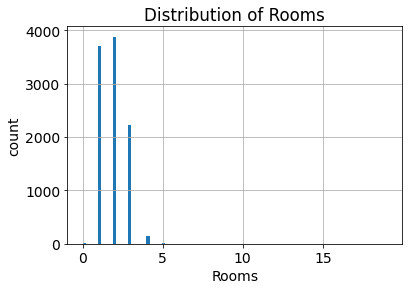

In [247]:
feature_name = 'Rooms'
df[feature_name].hist(bins=100)
plt.ylabel('count')
plt.xlabel(feature_name)

plt.title('Distribution of ' + feature_name)
plt.show()

In [248]:
df[(df[feature_name] > 5) | (df[feature_name] < 1)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2004,5927,57,10.0,59.056976,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.312500
2194,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.109375
2728,14865,9,10.0,60.871265,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.265625
3780,7317,27,0.0,41.790882,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976562
5894,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.343750
6088,8491,1,19.0,42.006046,21.779287,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.617188
6401,9443,27,0.0,87.762619,85.125473,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.921875
7644,7917,27,0.0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.250000
7929,456,6,0.0,81.491447,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.796875
8794,14003,99,6.0,59.414333,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.968750


In [249]:
df.groupby('Rooms')['Square'].agg('median')

Rooms
0.0      65.487473
1.0      40.406590
2.0      55.841812
3.0      77.413643
4.0      98.668060
5.0     116.084862
6.0      59.414333
10.0     59.964119
19.0     42.006046
Name: Square, dtype: float32

40.41 (**15.43** 48.125) 55.84 (**21.6** 66.64) 77.41 (**21.26** 88.04) 98.67 (**17.41** 107.375) 116.08 ()



In [250]:
98.67 + 17.41 / 2

107.375

In [251]:
# if df['Square'] < 48.125: return 1
# if df['Square'] < 66.64: return 2
# if df['Square'] < 88.04: return 3
# if df['Square'] < 107.375: return 4
# if df['Square'] >= 107.375: return 5

## Подготовка данных

In [252]:
df = None
train_valid_df = pd.read_csv(TRAIN_DATASET_PATH)
train_valid_df = reduce_mem_usage(train_valid_df)

train_df, valid_df = train_test_split(train_valid_df, test_size=0.33, shuffle=True, random_state=42)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [253]:
valid_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6252,3367,3,3.0,101.862701,99.970062,11.0,7,15.0,2013,0.050900,B,B,43,10621,1,30.0,2,3,B,225202.093750
4684,13670,22,1.0,87.485626,NaN,0.0,16,0.0,1977,0.118537,B,B,30,6207,1,1183.0,1,0,B,361744.281250
1731,14507,152,2.0,40.649902,22.288673,7.0,6,9.0,1964,0.042032,B,B,37,6856,84,1940.0,2,5,B,275055.187500
4742,11707,41,1.0,42.909801,20.923332,9.0,14,16.0,1980,0.175055,B,B,36,10055,3,NaN,1,0,B,198133.703125
4521,12298,53,1.0,35.108196,22.155378,9.0,5,12.0,1967,0.049637,B,B,34,7759,0,229.0,1,3,B,221299.453125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744,6584,6,2.0,67.299599,NaN,1.0,13,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,173816.250000
9754,14696,23,2.0,57.657177,NaN,1.0,3,3.0,1977,0.005767,B,B,1,388,0,NaN,0,0,B,93493.640625
6094,2904,6,2.0,65.929863,NaN,1.0,3,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,174858.765625
8781,12264,6,1.0,48.611847,NaN,1.0,20,25.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,134462.484375


### X_train, y_train

In [254]:
data_pipe = DataPipeline()
data_pipe.fit(train_df)
train_df = data_pipe.transform(train_df)

feature_names = get_feature_names(train_df, target_name)

y_train = train_df[target_name]
X_train = scale_features(train_df, fit=True)

In [255]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6700 entries, 8371 to 7270
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Id                       6700 non-null   int16   
 1   DistrictId               6700 non-null   int16   
 2   Rooms                    6700 non-null   float32 
 3   Square                   6700 non-null   float32 
 4   LifeSquare               6700 non-null   float32 
 5   KitchenSquare            6700 non-null   float32 
 6   Floor                    6700 non-null   int8    
 7   HouseFloor               6700 non-null   float32 
 8   HouseYear                6700 non-null   int32   
 9   Ecology_1                6700 non-null   float32 
 10  Ecology_2                6700 non-null   category
 11  Ecology_3                6700 non-null   category
 12  Social_1                 6700 non-null   int8    
 13  Social_2                 6700 non-null   int16   
 14  Socia

In [256]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6700 entries, 0 to 6699
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Rooms                    6700 non-null   float64
 1   Square                   6700 non-null   float64
 2   Floor                    6700 non-null   float64
 3   HouseFloor               6700 non-null   float64
 4   HouseYear                6700 non-null   float64
 5   Ecology_1                6700 non-null   float64
 6   Social_1                 6700 non-null   float64
 7   Social_2                 6700 non-null   float64
 8   Social_3                 6700 non-null   float64
 9   Healthcare_1             6700 non-null   float64
 10  Helthcare_2              6700 non-null   float64
 11  Shops_1                  6700 non-null   float64
 12  SquareOutlier            6700 non-null   float64
 13  RoomsOutlier             6700 non-null   float64
 14  HouseAge                

### X_valid, y_valid

In [257]:
valid_df = data_pipe.transform(valid_df)
y_valid = valid_df[target_name]
X_valid = scale_features(valid_df, fit=False)

In [258]:
y_valid

6252    225202.093750
4684    361744.281250
1731    275055.187500
4742    198133.703125
4521    221299.453125
            ...      
1744    173816.250000
9754     93493.640625
6094    174858.765625
8781    134462.484375
9401    128834.492188
Name: Price, Length: 3300, dtype: float32

### X_test

In [259]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df = reduce_mem_usage(test_df)
test_df.describe()

test_df = data_pipe.transform(test_df)
X_test = scale_features(test_df, fit=False)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


## LinearRegression

### Обучение модели

R2:	0.624
RMSE:	55960.199
MSE:	3131543927.598


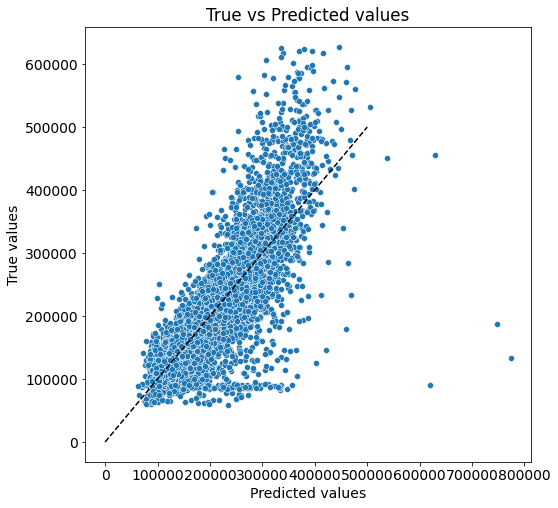

In [260]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)
# Постпроцессинг
# y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500000)

evaluate_preds(y_train, y_train_preds)

Text(0, 0.5, 'Признак')

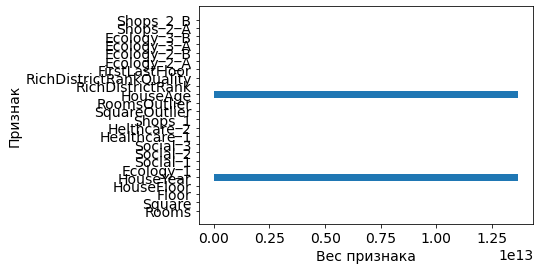

In [261]:
plt.barh(X_train.columns, lr_model.coef_.flatten())
plt.xlabel('Вес признака')
plt.ylabel('Признак')

### Валидация

R2:	0.595
RMSE:	61078.09
MSE:	3730533110.382


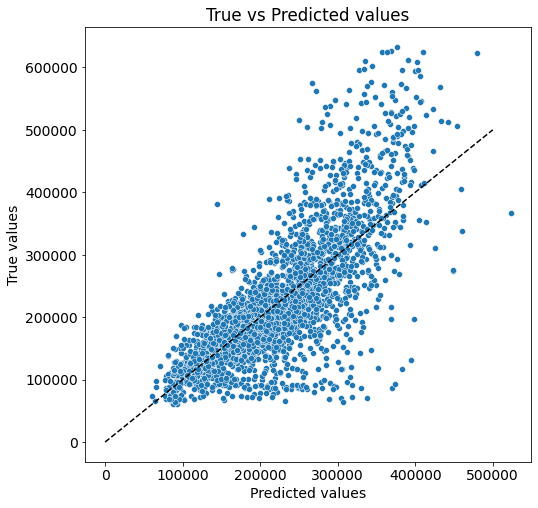

In [262]:
y_valid_preds = lr_model.predict(X_valid)
# Постпроцессинг
# y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500000)

evaluate_preds(y_valid, y_valid_preds)

## GridSearchCV

### Определяем гиперпараметры

In [263]:
gb_model = GradientBoostingRegressor(criterion='mse',
                          min_samples_leaf=10,
                          random_state=42,
                         # n_estimators=100,
                         # max_depth=7
                         )

In [264]:
%%time
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10]}

gs = GridSearchCV(gb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
# gs.fit(X_train, y_train)
# CPU times: user 4.62 s, sys: 241 ms, total: 4.87 s
# Wall time: 4min 4s

CPU times: user 71 µs, sys: 0 ns, total: 71 µs
Wall time: 76.3 µs


In [265]:
# gs.best_params_
# {'max_depth': 7, 'n_estimators': 100}

In [266]:
# gs.best_score_
0.7499443854653987

0.7499443854653987

### Обучение модели

In [267]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=7,
                                        min_samples_leaf=10,
                                        random_state=42,
                                        n_estimators=100)

final_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.908
RMSE:	27715.318
MSE:	768138866.899


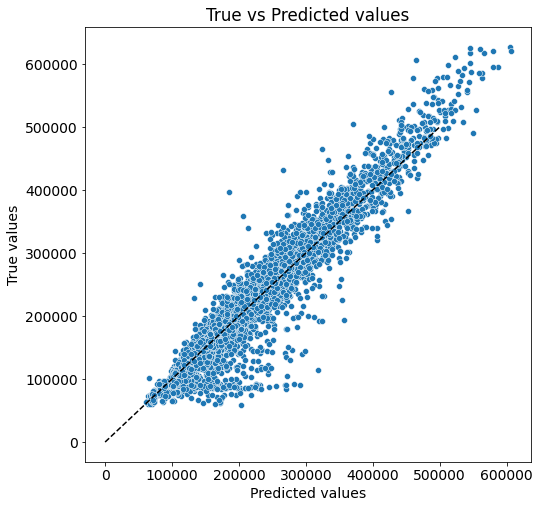

In [268]:
y_train_preds = final_model.predict(X_train)
evaluate_preds(np.squeeze(y_train.values), y_train_preds)

### Валидация

R2:	0.724
RMSE:	50413.749
MSE:	2541546101.973


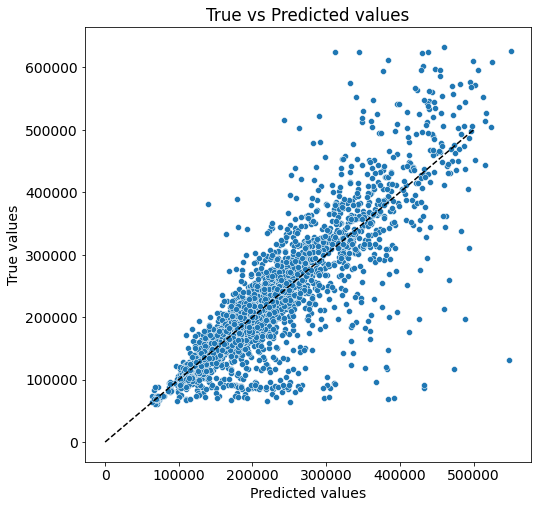

In [269]:
y_valid_preds = final_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

### Прогнозы

In [270]:
y_test_preds = final_model.predict(X_test)
y_test_preds

array([174026.65210255, 122486.50051763, 139704.27605003, ...,
       148200.37766441, 185244.26064207, 292186.30672625])

## Формирование файла с прогнозами

In [271]:
test_id = test_df["Id"]
test_price = y_test_preds
pred_df = pd.DataFrame()
pred_df["Id"] = test_id
pred_df["Price"] = test_price
assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"

pred_df.to_csv(PREDICTIONS_PATH, index=False)

In [272]:
pred_df = pd.read_csv(PREDICTIONS_PATH)
pred_df.head()

,Id,Price
0,4567,174026.652103
1,5925,122486.500518
2,960,139704.276050
3,3848,111258.128339
4,746,170391.447482
